# Sampling raster data

Many GIS tasks involve both raster and vector data. In this demo, we have a shapefile containing the coordinates of four campsites in Mt. Rainier and we want to extract the elevation from a corresponding raster file (that was introduced in [Week 9](../demos/09a-demo.ipynb).

In [132]:
import rasterio
from rasterio.mask import mask
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

# Import raster 
src = rasterio.open('data/N46W122.tif')
elevations = src.read(1)

# Import shapefile
campsites = gpd.read_file('data/campsites.shp')

## Check coordinates

Before we can extract the elevation values beneath the points, we must check that the two datasets have the same coordinate reference system. 

In [81]:
campsites.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [82]:
src.crs

CRS.from_epsg(4326)

It looks they are both projected in **WGS84 (EPSG:4325)** so we can move onto the next step.

## Plot

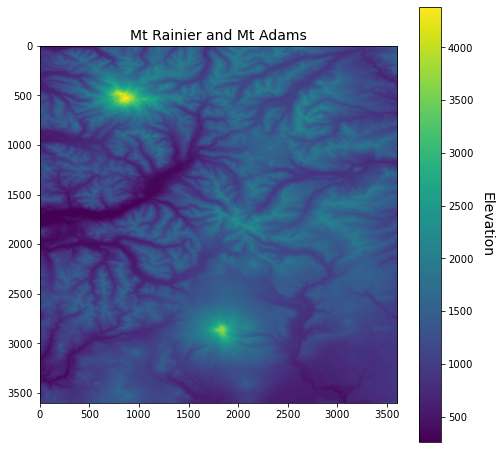

In [138]:
# Plot data
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(elevations)
ax.set_title("Mt Rainier and Mt Adams", fontsize=14)
cbar = fig.colorbar(im, orientation='vertical')
cbar.ax.set_ylabel('Elevation', rotation=270, fontsize=14)
cbar.ax.get_yaxis().labelpad = 20

## Sampling the data

`Rasterio's` [`sample`](https://rasterio.readthedocs.io/en/latest/api/rasterio.sample.html) function expects a list of x, y coordinate pairs so we need to convert our `geometry` column using list comprehension. 

In [84]:
coord_list = [(x,y) for x,y in zip(campsites['geometry'].x , campsites['geometry'].y)]
coord_list

[(-121.86309568977, 46.9328599291782),
 (-121.644123657629, 46.9024017663544),
 (-121.566675005534, 46.73861426056),
 (-121.794055025156, 46.7676258113237)]

Now we can carry out the sample and store the results in new column called **elevation**. Note that if the image has more than one band, a value is returned for each band.

In [85]:
campsites['elevation'] = [x for x in src.sample(coord_list)]
campsites.head()

,campsite,lat,lon,geometry,elevation
0,mowich lake,46.932860,-121.863096,POINT (-121.86310 46.93286),[1505]
1,white river,46.902402,-121.644124,POINT (-121.64412 46.90240),[1331]
2,ohanapecosh,46.738614,-121.566675,POINT (-121.56668 46.73861),[609]
3,cougar rock,46.767626,-121.794055,POINT (-121.79406 46.76763),[975]


## Buffer points

Sometimes it might be a little risky to sample only one cell per point. There may be errors or artifacts in the unerlying raster. A more robust method would be to sample multiple raster grid cells surrounding a point. To do this we could **buffer** the points by a set distance and sample the raster values again.  

`GeoPandas` has a method called [`buffer`](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) which expects a **distance** around each object. Since our shapefile is in WGS84 coordinate system, this distance would have to be in **degrees** which is a little confusing. A better option would be to reproject our shapefile so we can enter a buffer distance in **meters**. 

In [86]:
campsites_utm = campsites.to_crs('EPSG:32610')
campsites_utm['buffer'] = campsites_utm.buffer(500)
campsites_utm

,campsite,lat,lon,geometry,elevation,buffer
0,mowich lake,46.932860,-121.863096,POINT (586541.645 5198330.423),[1505],"POLYGON ((587041.645 5198330.423, 587039.237 5..."
1,white river,46.902402,-121.644124,POINT (603268.211 5195210.763),[1331],"POLYGON ((603768.211 5195210.763, 603765.804 5..."
2,ohanapecosh,46.738614,-121.566675,POINT (609498.970 5177115.438),[609],"POLYGON ((609998.970 5177115.438, 609996.562 5..."
3,cougar rock,46.767626,-121.794055,POINT (592078.991 5180047.801),[975],"POLYGON ((592578.991 5180047.801, 592576.583 5..."


Now we have two columns containing **geometry** values. But a `GeoDataFrame` can only have one active geometry. Since we intend to use our buffer geometry to sample the raster data, we will make our **buffer** column the active geometry.

In [91]:
campsites_utm.set_geometry('buffer', inplace=True)

We have to convert the DataFrame back to WGS84 so it has the same projection system as our raster data.

In [92]:
campsites = campsites_utm.to_crs('EPSG:4326')

To sample raster grid cells within polygons (rather than points) we use another `Rasterio` function called [`mask.mask`](https://rasterio.readthedocs.io/en/latest/api/rasterio.mask.html#). This function has a few arguments. The first is the raster dataset (i.e. `src` in our case). The second argument is the shape to mask. In the docs, it notes that the shapes must be:

> a GeoJSON-like dict or an object that implements the Python geo interface protocol (such as a Shapely Polygon)"

So we will have to specify only the **geometry** of our `GeoPandas` DataFrame, not the DataFrame object itself. The **Invert** argument determines whether pixels inside or outside shapes will be masked. The **nodata** argument allows us to set the no data value (i.e. values of pixels outside the mask). 

In [100]:
campsite_mask, transform = mask(src, campsites.geometry, invert=False, nodata=0)

Now when we plot our data, we should see four small dots that represent elevation values within 500 m of the campsites. All other elevation values are assigned a no data values. 

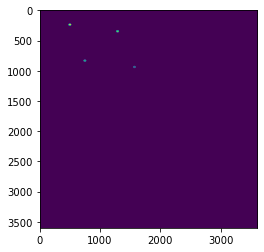

In [101]:
plt.imshow(campsite_mask[0,:,:])

## Regionprops

The challenge is to extract the values of grid cells within the buffer. 

In [157]:
from skimage.measure import label

Convert to binary array (i.e. ones and zeros)

In [112]:
campsites = np.where(campsite_mask[0,:,:] > 0, 1, 0)

Label image

In [116]:
label_img = label(campsites)

Print unique labels

In [117]:
np.unique(label_img)

array([0, 1, 2, 3, 4])

In [140]:
elevations[label_img == 0].shape

(12962407,)

In [141]:
elevations[label_img == 1].shape

(1198,)

In [126]:
elevations[label_img == 1].mean(), elevations[label_img == 1].std()

(1538.70367278798, 61.23086259469098)

In [127]:
elevations[label_img == 2].mean(), elevations[label_img == 2].std()

(1380.375312760634, 75.87074248803795)

In [128]:
elevations[label_img == 3].mean(), elevations[label_img == 3].std()

(1007.7948290241868, 58.850863432257526)

In [129]:
elevations[label_img == 4].mean(), elevations[label_img == 4].std()

(638.1961602671118, 33.699186100766795)

In [149]:


np.argwhere(label_img == 1)

array([[226, 488],
       [226, 489],
       [226, 490],
       ...,
       [257, 498],
       [257, 499],
       [257, 500]])

In [155]:
rasterio.transform.rowcol(src.transform, campsites['geometry'].x[0], campsites['geometry'].y[0]) in np.argwhere(label_img == 1)

True

In [152]:
campsites['geometry']., campsites['geometry'].y[0]

(-121.86309568977, 46.9328599291782)

In [156]:
campsites

,campsite,lat,lon,geometry
0,mowich lake,46.932860,-121.863096,POINT (-121.86310 46.93286)
1,white river,46.902402,-121.644124,POINT (-121.64412 46.90240)
2,ohanapecosh,46.738614,-121.566675,POINT (-121.56668 46.73861)
3,cougar rock,46.767626,-121.794055,POINT (-121.79406 46.76763)


It got a little messy at the end there but that's par for the course in geospatial analysis. 